In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize the images to [-1, 1] range
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)

# Define some constants
BUFFER_SIZE = 60000
BATCH_SIZE = 128
NOISE_DIM = 100
NUM_CLASSES = 10
EPOCHS = 10000
SAVE_INTERVAL = 1000

In [ ]:
def build_generator():
    noise_input = layers.Input(shape=(NOISE_DIM,))
    label_input = layers.Input(shape=(NUM_CLASSES,))

    merged_input = layers.Concatenate()([noise_input, label_input])

    x = layers.Dense(256)(merged_input)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.Dense(np.prod((28, 28, 1)), activation='tanh')(x)
    img = layers.Reshape((28, 28, 1))(x)

    model = models.Model([noise_input, label_input], img)
    return model

In [ ]:
def build_discriminator():
    img_input = layers.Input(shape=(28, 28, 1))
    label_input = layers.Input(shape=(NUM_CLASSES,))

    # Flatten the image input
    flat_img = layers.Flatten()(img_input)

    # Concatenate flattened image and label inputs
    merged_input = layers.Concatenate()([flat_img, label_input])

    x = layers.Dense(512)(merged_input)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    validity = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model([img_input, label_input], validity)
    return model


In [ ]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    noise_input = layers.Input(shape=(NOISE_DIM,))
    label_input = layers.Input(shape=(NUM_CLASSES,))
    img = generator([noise_input, label_input])
    validity = discriminator([img, label_input])
    model = models.Model([noise_input, label_input], validity)
    return model

4/4 [==============================] - 0s 9ms/step
0 [D loss: 0.7498053908348083, acc.: 30.46875] [G loss: 0.5373737812042236]
1/1 [==============================] - 0s 121ms/step


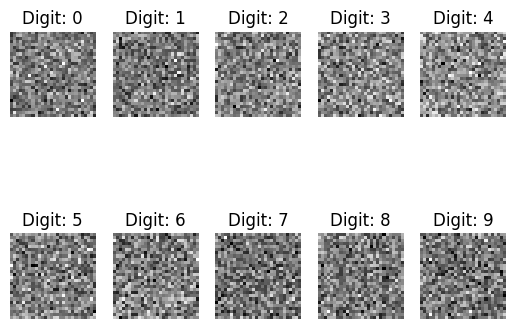

4/4 [==============================] - 0s 7ms/step
1000 [D loss: 0.0034776011016219854, acc.: 100.0] [G loss: 9.703927993774414]
1/1 [==============================] - 0s 23ms/step


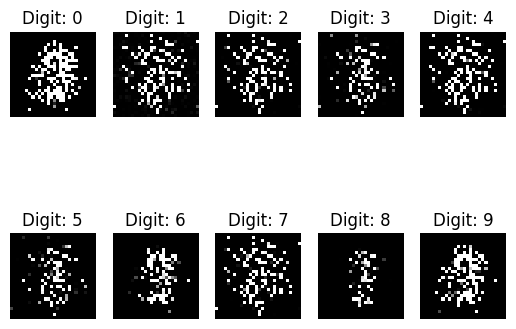

4/4 [==============================] - 0s 7ms/step
2000 [D loss: 0.028509325813502073, acc.: 98.828125] [G loss: 8.850545883178711]
1/1 [==============================] - 0s 23ms/step


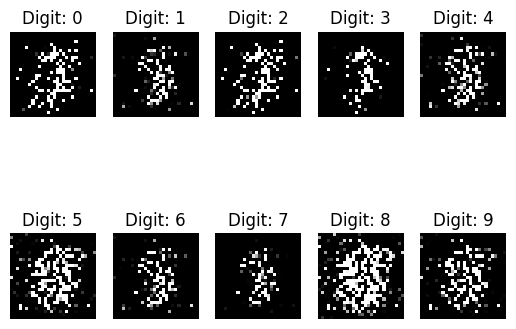

4/4 [==============================] - 0s 9ms/step
3000 [D loss: 0.01250502560287714, acc.: 99.609375] [G loss: 6.814064025878906]
1/1 [==============================] - 0s 32ms/step


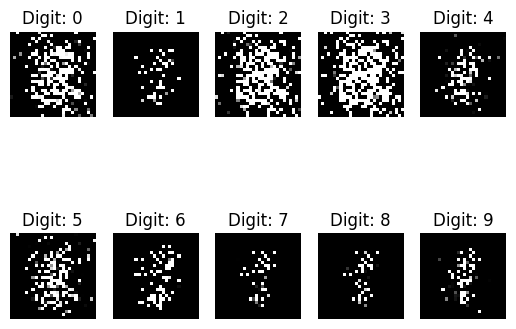

4/4 [==============================] - 0s 8ms/step
4000 [D loss: 0.006579987471923232, acc.: 100.0] [G loss: 8.764678001403809]
1/1 [==============================] - 0s 30ms/step


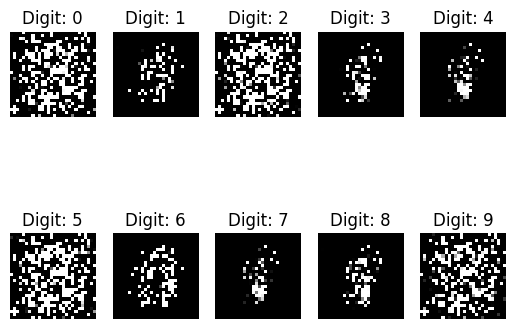

4/4 [==============================] - 0s 7ms/step
5000 [D loss: 0.023271060548722744, acc.: 99.609375] [G loss: 5.934567451477051]
1/1 [==============================] - 0s 28ms/step


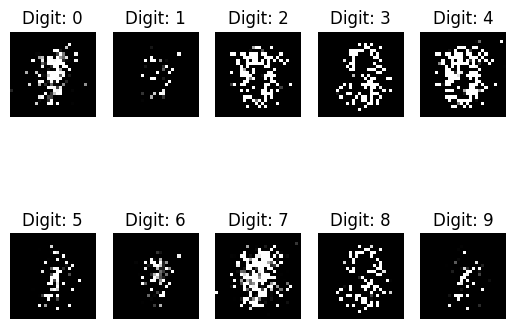

4/4 [==============================] - 0s 13ms/step
6000 [D loss: 0.011727381963282824, acc.: 100.0] [G loss: 7.360237121582031]
1/1 [==============================] - 0s 36ms/step


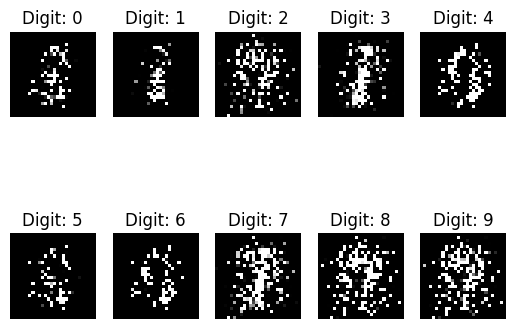

4/4 [==============================] - 0s 7ms/step
7000 [D loss: 0.027373280376195908, acc.: 98.828125] [G loss: 6.690608024597168]
1/1 [==============================] - 0s 29ms/step


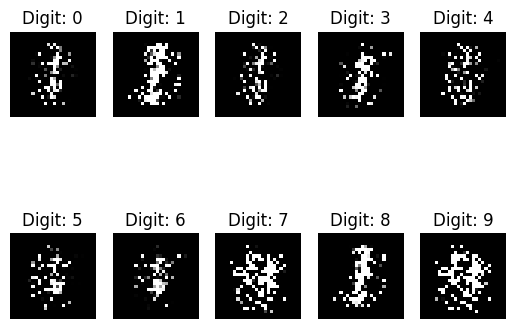

4/4 [==============================] - 0s 8ms/step
8000 [D loss: 0.003202478401362896, acc.: 100.0] [G loss: 8.084965705871582]
1/1 [==============================] - 0s 28ms/step


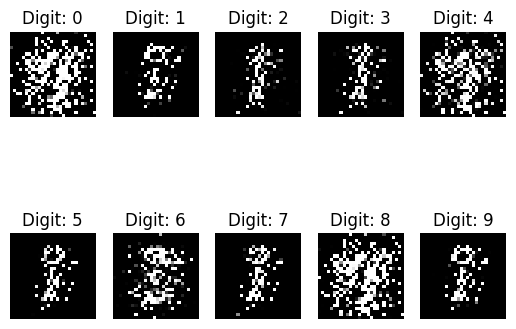

4/4 [==============================] - 0s 8ms/step
9000 [D loss: 0.02002810686826706, acc.: 99.609375] [G loss: 7.5865159034729]
1/1 [==============================] - 0s 45ms/step


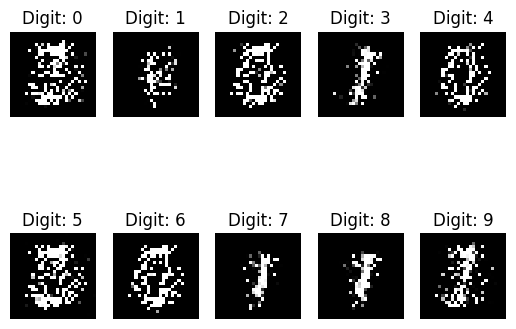

4/4 [==============================] - 0s 9ms/step


In [ ]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the generator
generator = build_generator()

# Build and compile the GAN
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Training function
def train(epochs, batch_size=128, save_interval=200):
    # Load and preprocess the data
    X_train = x_train
    y_train_cat = y_train

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train_cat[idx]

        noise = np.random.normal(0, 1, (batch_size, NOISE_DIM))
        gen_labels = np.random.randint(0, NUM_CLASSES, batch_size)
        gen_labels_cat = tf.keras.utils.to_categorical(gen_labels, NUM_CLASSES)

        gen_imgs = generator.predict([noise, gen_labels_cat])

        d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, gen_labels_cat], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, NOISE_DIM))
        sampled_labels = np.random.randint(0, NUM_CLASSES, batch_size)
        sampled_labels_cat = tf.keras.utils.to_categorical(sampled_labels, NUM_CLASSES)

        g_loss = gan.train_on_batch([noise, sampled_labels_cat], valid)

        # Print the progress
        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")
            save_imgs(epoch)

def save_imgs(epoch):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, NOISE_DIM))
    sampled_labels = np.arange(0, NUM_CLASSES).reshape(-1, 1)
    sampled_labels_cat = tf.keras.utils.to_categorical(sampled_labels, NUM_CLASSES)
    gen_imgs = generator.predict([noise, sampled_labels_cat])

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].set_title(f"Digit: {cnt}")
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# Train the GAN
train(EPOCHS, BATCH_SIZE, SAVE_INTERVAL)